<a href="https://colab.research.google.com/github/imenFerjani/NLP_Job_Skills_match/blob/main/final_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Mounting Google drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/My Drive/resume-to-job-matcher-Spacy--master/five_class_entitydata'

/content/drive/My Drive/resume-to-job-matcher-Spacy--master/five_class_entitydata


In [ ]:
!pip install spacy==2.0.18

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.2 MB 58.1 MB/s 
     |████████████████████████████████| 1.9 MB 36.5 MB/s 
     |████████████████████████████████| 612 kB 42.6 MB/s 
     |████████████████████████████████| 150 kB 38.6 MB/s 
     |████████████████████████████████| 82 kB 342 kB/s 
     |████████████████████████████████| 443 kB 39.1 MB/s 
     |████████████████████████████████| 138 kB 47.1 MB/s 
  Created wheel for regex: filename=regex-2018.1.10-cp37-cp37m-linux_x86_64.whl size=549190 sha256=27e408ad09002282f1331ab38c0db1d8d648a1ad2fa1a21418e939458de4f351
  Stored in directory: /root/.cache/pip/wheels/ba/ec/25/0c2b801e792098f7dad5b76157b01be8d0719525c365773e7c
  Created wheel for dill: filename=dill-0.2.9-py3-none-any.whl size=77420 sha256=91f0bb8e0c62716ad9ebf9909f0c5138440d3d9b588b11a4b4271a86861abb01
  Stored in directory: /root/.cache/pip/wheels/31/87/19/1fb8f037d75fdc0841c772e

### Imports


In [ ]:
import os
import spacy 
import re
import json
import random
import logging
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from spacy.gold import GoldParse
from spacy.scorer import Scorer
from sklearn.metrics import accuracy_score

### Converting dataturks to spacy format


In [ ]:
#converting dataturks annotated data to spacy format to be 
#used as training data

def convert_dataturks_to_spacy(dataturks_JSON_FilePath):
    try:
        training_data = []
        lines=[]
        with open(dataturks_JSON_FilePath, 'r') as f:
            lines = f.readlines()

        for line in lines:
            #print("line=",line)
            data = json.loads(line)
            text = data['content']
            entities = []
            for annotation in data['annotation']:
                #only a single point in text annotation.
                point = annotation['points'][0]
                labels = annotation['label']
                # handle both list of labels or a single label.
                if not isinstance(labels, list):
                    labels = [labels]

                for label in labels:
                    #print("label=",label)
                    #dataturks indices are both inclusive [start, end] but spacy is not [start, end)
                    entities.append((point['start'], point['end'] + 1 ,label))


            training_data.append((text, {"entities" : entities}))

        return training_data
    except Exception as e:
        logging.exception("Unable to process " + dataturks_JSON_FilePath + "\n" + "error = " + str(e))
        return None

### Cleaning data


In [ ]:
############################Removes leading and trailing white spaces from entity spans.############################
# https://github.com/explosion/spaCy/issues/3558
def trim_entity_spans(data: list):
    """Removes leading and trailing white spaces from entity spans.

    Args:
        data (list): The data to be cleaned in spaCy JSON format.

    Returns:
        list: The cleaned data.
    """
    invalid_span_tokens = re.compile(r'\s')

    cleaned_data = []
    for text, annotations in data:
        #print(text,annotations)
        entities = annotations['entities']
        valid_entities = []
        for start, end, label in entities:
            #print("start=",start,"end=",end)
            valid_start = start
            valid_end = end
            #print("text=",text)
            while valid_start < len(text) and invalid_span_tokens.match(text[valid_start]):valid_start += 1
            while valid_end > 1 and invalid_span_tokens.match(text[valid_end-1]):valid_end -= 1
            valid_entities.append([valid_start, valid_end, label])
        cleaned_data.append([text, {'entities': valid_entities}])

    return cleaned_data

### Training the model


In [ ]:
################### Train Spacy NER.###########
def train_spacy():
    TRAIN_DATA = convert_dataturks_to_spacy("/content/drive/My Drive/five_class_entitydata/traindata_3withmyannotation.json")
    #print("OK1")
    TRAIN_DATA=trim_entity_spans(TRAIN_DATA)
    #print("OK2")
    nlp = spacy.blank('en')  # create blank Language class
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    # if 'tagger' not in nlp.pipe_names:
    #      nlp.add_pipe(nlp.create_pipe('tagger'))
    if 'ner' not in nlp.pipe_names:
        ner = nlp.create_pipe('ner')
        nlp.add_pipe(ner, last=True)

       
       
    # add labels
    for _, annotations in TRAIN_DATA:
         for ent in annotations.get('entities'):
            ner.add_label(ent[2])

    # get names of other pipes to disable them during training
    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
    with nlp.disable_pipes(*other_pipes):  # only train NER
        optimizer = nlp.begin_training()
        for itn in range(10):
            print("Statring iteration " + str(itn))
            random.shuffle(TRAIN_DATA)
            losses = {}
            for text, annotations in TRAIN_DATA:
                nlp.update(
                    [text],  # batch of texts
                    [annotations],  # batch of annotations
                    drop=0.1,  # dropout - make it harder to memorise data
                    sgd=optimizer,  # callable to update weights
                    losses=losses)
            print(losses)
    return nlp

In [ ]:
nlp_=train_spacy()

Statring iteration 0
{'ner': 10693.723300623464}
Statring iteration 1
{'ner': 6045.237990541552}
Statring iteration 2
{'ner': 4287.5382039780325}
Statring iteration 3
{'ner': 3730.3322702509035}
Statring iteration 4
{'ner': 3032.364425171096}
Statring iteration 5
{'ner': 2394.790546561405}
Statring iteration 6
{'ner': 2087.9132011658985}
Statring iteration 7
{'ner': 1830.7260804357254}
Statring iteration 8
{'ner': 1697.6425553191766}
Statring iteration 9
{'ner': 1398.245892008394}


### Saving the Trained model


In [ ]:
# save model to output directory (with parcial cleaned data)
def save_model(output_dir):
      nlp_.to_disk(output_dir)
      print("Saved model to", output_dir)


In [ ]:
output_dir='./model2'
save_model(output_dir)

Saved model to ./model2


### Loading the trained model instance


In [ ]:
 ###################loading the saved model################################
 output_dir='./model2'
 nlp2 = spacy.load(output_dir)

In [ ]:
!ls

 3class_test_data.json			   resume20.txt
'3class_train_data .json'		   resume21.txt
 cv					   resume22.txt
 indeed_jobs_info_backend_developer.json   resume23.txt
 jobs					   resume24.txt
 model1					   resume25.txt
 model2					   resume26.txt
 resume0.txt				   resume27.txt
 resume10.txt				   resume28.txt
 resume11.txt				   resume2.txt
 resume12.txt				   resume3.txt
 resume13.txt				   resume4.txt
 resume14.txt				   resume5.txt
 resume15.txt				   resume6.txt
 resume16.txt				   resume7.txt
 resume17.txt				   resume8.txt
 resume18.txt				   resume9.txt
 resume19.txt				   traindata_3withmyannotation.json
 resume1.txt


### Testing


In [ ]:
##############################preparing the testdata########################
examples = convert_dataturks_to_spacy('/content/drive/My Drive/resume-to-job-matcher-Spacy--master/five_class_entitydata/3class_test_data.json')
examples=trim_entity_spans(examples)
tp = 0
tr = 0
tf = 0

ta = 0
c = 0


In [ ]:


#################testing the model######################
nlp_=nlp2
for text, annot in examples:

    f = open("resume"+str(c)+".txt", "w")
    doc_to_test = nlp_(text)
    d = {}
    for ent in doc_to_test.ents:
        d[ent.label_] = []
    for ent in doc_to_test.ents:
        d[ent.label_].append(ent.text)
        
    if 'Skills' in d:
      skills_=d['Skills']    
      print(f'resume {str(c)} skills {skills_}')
    # print(d.keys())

    #---------------------------      
    for i in set(d.keys()):

        f.write("\n\n")
        f.write(i + ":"+"\n")
        for j in set(d[i]):
            f.write(j.replace('\n', '')+"\n")
    #-----------------------------
    d = {}
    for ent in doc_to_test.ents:
        d[ent.label_] = [0, 0, 0, 0, 0, 0]
    for ent in doc_to_test.ents:
        doc_gold_text = nlp_.make_doc(text)
        gold = GoldParse(doc_gold_text, entities=annot.get("entities"))
        y_true = [ent.label_ if ent.label_ in x else 'Not ' +
                  ent.label_ for x in gold.ner]
        y_pred = [x.ent_type_ if x.ent_type_ ==
                  ent.label_ else 'Not '+ent.label_ for x in doc_to_test]
        if(d[ent.label_][0] == 0):
            # f.write("For Entity "+ent.label_+"\n")
            #print(classification_report(y_true, y_pred)+"\n")
            (p, r, f, s) = precision_recall_fscore_support(
                y_true, y_pred, average='weighted')
            a = accuracy_score(y_true, y_pred)
            #plot_confusion_matrix_(y_true,y_pred)
            d[ent.label_][0] = 1
            d[ent.label_][1] += p
            d[ent.label_][2] += r
            d[ent.label_][3] += f
            d[ent.label_][4] += a
            d[ent.label_][5] += 1
            break
    c += 1


resume 1 skills ['Machine Learning', 'Python', 'Matlab', 'SQL', 'Splunk', 'Tableau', 'Hadoop', 'ABAP', 'Web services']
resume 2 skills ['Python', 'Python', 'Python', 'Perl', 'C', 'C++', 'Javascript', 'Hadoop', 'Jquery', 'Javascript', 'XML', 'HTML', 'Jquery', 'Perl', 'Apache', 'Jquery', 'Perl', 'Apache', 'Jquery', 'Python', 'XML', 'ms-access', 'Log Manager', 'Server Manager', 'Server Manager', 'Web Development', 'Data structures']
resume 3 skills ['Machine Learning']
resume 4 skills ['machine learning', 'Data Science', 'Python', 'Python', 'Machine Learning', 'Big Data-Learning', 'Hadoop']
resume 5 skills ['Business/Data/Predictive/TextAnalytics', 'Data Analyst', 'System Analyst', 'System Engineer', 'SQL', 'Machine Learning']
resume 6 skills ['ML', 'Python', 'Machine Learning', 'machine learning', 'Python', 'R', 'Kafka', 'HDFS', 'SQL', 'Python', 'Hive', 'SQL', 'Java', 'C#.NET', 'Big Data Ecosystem', 'SQL SERVER', 'Big Data Tools', 'Python', 'Machine Learning', 'Deep Learning', 'NLP', 'Te

In [ ]:
#################testing the model######################
nlp_=nlp2
for text, annot in examples:

    f = open("resume"+str(c)+".txt", "w")
    doc_to_test = nlp_(text)
    d = {}
    for ent in doc_to_test.ents:
        d[ent.label_] = []
    for ent in doc_to_test.ents:
        d[ent.label_].append(ent.text)
        
    if 'Skills' in d:
      skills_=d['Skills']    
      print(f'resume {str(c)} skills {skills_}')
    # print(d.keys())

    #---------------------------      
    for i in set(d.keys()):

        f.write("\n\n")
        f.write(i + ":"+"\n")
        for j in set(d[i]):
            f.write(j.replace('\n', '')+"\n")
    #-----------------------------
    d = {}
    for ent in doc_to_test.ents:
        d[ent.label_] = [0, 0, 0, 0, 0, 0]
    for ent in doc_to_test.ents:
        doc_gold_text = nlp_.make_doc(text)
        gold = GoldParse(doc_gold_text, entities=annot.get("entities"))
        y_true = [ent.label_ if ent.label_ in x else 'Not ' +
                  ent.label_ for x in gold.ner]
        y_pred = [x.ent_type_ if x.ent_type_ ==
                  ent.label_ else 'Not '+ent.label_ for x in doc_to_test]
        if(d[ent.label_][0] == 0):
            # f.write("For Entity "+ent.label_+"\n")
            # f.write(classification_report(y_true, y_pred)+"\n")
            (p, r, f, s) = precision_recall_fscore_support(
                y_true, y_pred, average='weighted')
            a = accuracy_score(y_true, y_pred)
            print("For Entity "+ent.label_+"\n")
            print(len(y_true),len(y_pred))
            #plot_confusion_matrix_(y_true,y_pred)
            d[ent.label_][0] = 1
            d[ent.label_][1] += p
            d[ent.label_][2] += r
            d[ent.label_][3] += f
            d[ent.label_][4] += a
            d[ent.label_][5] += 1
    c += 1

For Entity Name

2396 2396
For Entity Education

2396 2396
For Entity Location

2396 2396
resume 30 skills ['Machine Learning', 'Python', 'Matlab', 'SQL', 'Splunk', 'Tableau', 'Hadoop', 'ABAP', 'Web services']
For Entity Name

1148 1148
For Entity Skills

1148 1148
For Entity Location

1148 1148


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


resume 31 skills ['Python', 'Python', 'Python', 'Perl', 'C', 'C++', 'Javascript', 'Hadoop', 'Jquery', 'Javascript', 'XML', 'HTML', 'Jquery', 'Perl', 'Apache', 'Jquery', 'Perl', 'Apache', 'Jquery', 'Python', 'XML', 'ms-access', 'Log Manager', 'Server Manager', 'Server Manager', 'Web Development', 'Data structures']
For Entity Name

2111 2111
For Entity Skills

2111 2111


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For Entity Education

2111 2111
For Entity Location

2111 2111
resume 32 skills ['Machine Learning']
For Entity Name

891 891
For Entity Location

891 891


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For Entity Skills

891 891
resume 33 skills ['machine learning', 'Data Science', 'Python', 'Python', 'Machine Learning', 'Big Data-Learning', 'Hadoop']
For Entity Name

1442 1442
For Entity Skills

1442 1442
For Entity Location

1442 1442
resume 34 skills ['Business/Data/Predictive/TextAnalytics', 'Data Analyst', 'System Analyst', 'System Engineer', 'SQL', 'Machine Learning']
For Entity Skills

1447 1447
For Entity Location

1447 1447
resume 35 skills ['ML', 'Python', 'Machine Learning', 'machine learning', 'Python', 'R', 'Kafka', 'HDFS', 'SQL', 'Python', 'Hive', 'SQL', 'Java', 'C#.NET', 'Big Data Ecosystem', 'SQL SERVER', 'Big Data Tools', 'Python', 'Machine Learning', 'Deep Learning', 'NLP', 'Text mining', 'HDFS', 'MySql', 'R', 'Python', 'data mining', 'Python', 'Python', 'Python', 'Machine learning', 'Machine Learning', 'Deep Learning', 'Data visualization', 'Data mining', 'machine learning', 'Python', 'R', 'Python', 'MySQL', 'HDFS']
For Entity Name

2831 2831
For Entity Skills

283

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For Entity Location

1334 1334
For Entity Education

1334 1334
resume 37 skills ['Data Science', 'Machine Learning Modelling', 'machine learning', 'Python', 'Tableau', 'Python', 'Tableau', 'SQL', 'Machine Learning', 'machine learning', 'Python', 'Python', 'Tableau', 'SQL']
For Entity Name

1270 1270
For Entity Skills

1270 1270
For Entity Location

1270 1270
resume 38 skills ['Image Processing', 'Machine Learning', 'Computer Vision', 'Machine vision', 'Machine vision)', 'VC++', 'C++', 'Python', 'C++', 'Python', 'VC++', 'C++', 'C/C++', 'Machine Learning', 'Machine Learning', 'Tesseract', 'Machine Learning', 'Data Analysis', 'Machine Learning', 'Tesseract', 'C++', 'system testing', 'Machine Learning']
For Entity Name

1584 1584
For Entity Skills

1584 1584


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For Entity Location

1584 1584
resume 39 skills ['Python', 'Javascript', 'AngularJS', 'HTML', 'CSS', 'Python', 'Automation testing', 'Javascript', 'AngularJS', 'CSS']
For Entity Skills

1243 1243


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For Entity Location

1243 1243
For Entity Education

1243 1243
resume 40 skills ['Deep Learning', 'Deep Learning', 'Machine learning', 'Machine Learning', 'Machine learning', 'Machine Learning', 'Machine Learning', 'Deep Learning', 'Python', 'R programming', 'Python', 'Machine Learning Techniques', 'Python', 'Python']
For Entity Name

1566 1566
For Entity Skills

1566 1566
For Entity Education

1566 1566
For Entity Location

1566 1566


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


resume 41 skills ['machine learning', 'Data Analytics Tool', 'data mining                    \n\n', 'Data/Text Mining', 'Deep Learning', 'Machine Learning', 'data mining techniques']
For Entity Skills

1756 1756
For Entity Location

1756 1756
resume 42 skills ['R / Python', 'Python', 'Hive', 'Machine Learning', 'COBOL', 'JCL', 'Data Analyst']
For Entity Skills

866 866
resume 43 skills ['Python', 'Machine Learning']
For Entity Name

619 619
For Entity Location

619 619
For Entity Skills

619 619
resume 44 skills ['Tableau', 'Python', 'SAS', 'Machine Learning Techniques']
For Entity Location

956 956
For Entity Skills

956 956
resume 45 skills ['Python', 'Python', 'JQuery', 'MySQL']
For Entity Name

1425 1425
For Entity Location

1425 1425
For Entity Skills

1425 1425
resume 46 skills ['Python', 'Machine Learning', 'Python programming', 'Machine learning', 'Python', 'Machine Learning(Linear', 'machine learning', 'Python', 'Python']
For Entity Name

986 986
For Entity Location

986 986
F

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


For Entity Location

1304 1304
resume 56 skills ['R Programming', 'Machine Learning', 'SQL']
For Entity Skills

1485 1485
For Entity Name

1485 1485
resume 57 skills ['C CTC-5.5 LPA', 'R Programming', 'Unix Scripting', 'SAS', 'R programming']
For Entity Name

872 872
For Entity Skills

872 872
For Entity Location

872 872
For Entity Education

872 872


### Validating the pridiction


In [ ]:
###########################validating the model##########################
for i in d:
    print("\n For Entity "+i+"\n")
    print("Accuracy : "+str((d[i][4]/d[i][5])*100)+"%")
    print("Precision : "+str(d[i][1]/d[i][5]))
    print("Recall : "+str(d[i][2]/d[i][5]))
    print("F-score : "+str(d[i][3]/d[i][5]))


 For Entity Name

Accuracy : 100.0%
Precision : 1.0
Recall : 1.0
F-score : 1.0

 For Entity Location

Accuracy : 99.88532110091744%
Precision : 0.9988545276440661
Recall : 0.9988532110091743
F-score : 0.9986624088584894

 For Entity Skills

Accuracy : 98.85321100917432%
Precision : 0.9855690220049761
Recall : 0.9885321100917431
F-score : 0.9852820854703445

 For Entity Education

Accuracy : 100.0%
Precision : 1.0
Recall : 1.0
F-score : 1.0


### matcher


In [ ]:
import pandas as pd
from pathlib import Path

nlp_=nlp2

def find_skills(text):
  d = {}
  docx=nlp_(text)
  for ent in docx.ents:
    d[ent.label_] = []
  for ent in docx.ents:
    d[ent.label_].append(ent.text)
  if 'Skills' in d:
    skills_=d['Skills']    
    return skills_
  else:
    return None

### Creating job list


In [ ]:
# create jobs list
jobs=[]
job_dir='/content/drive/My Drive/resume-to-job-matcher-Spacy--master/five_class_entitydata/jobs2'
pathlist = Path(job_dir).glob('**/*.json')
for path in pathlist:

    with open (path, "r") as fileHandler:
      T=json.load(fileHandler)
      text1=""
      for e in T:text1+=' '+e['desc']

      job={
          'name':path.name,
           'skills':find_skills(text1)
      }
      if path.name=="phpdeveloper.json":
        job['skills'].append(['PHP', 'Laravel', 'CodeIgniter', 'Symfony', 'Zend', 'Phalcon', 'CakePHP', 'Yii', 'FuelPHP', 'React', 'Vue', 'Angular', 'Ember', 'Backbone'])
      if path.name=="javadeveloper.json":
        job['skills'].append(['IHS', 'WAS', 'Java EE', 'SQL Server', '.NET core', 'C#', 'ASP.NET', 'Rdlc', 'Linq', 'Sql', 'Web Api', 'Mvc', 'Javascript', 'Web Services', 'Oracle', 'MS SQL'])
      if path.name=="datascientist.json":
        job['skills'].append(['Data Science', 'Python', 'Machine Learning', 'SAS', 'Java', 'Scala', 'Hadoop', 'Hive', 'Bigdata', 'Programming', 'SQL server reporting', 'Msbi Ssis', 'Ssrs', 'Msbi', 'Sql Reporting', 'Artificial Intelligence', 'Pandas', 'Pyspark', 'Sklearn', 'Flask', 'Django', 'Map Reduce', 'Parametric Design', 'Modeling', 'Regression', 'Patterns', 'Data Mining', 'Text Mining', 'Oops', 'Deep Learning', 'Web Analytics', 'Time Series', 'Regression', 'Tensorflow', 'Azure', 'Linear Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Data Structure', 'Computer Vision'])
      if path.name=="backenddeveloper.json":
        job['skills'].append(8*['MySQL', 'PostgreSQL', 'Microsoft Access', 'SQL Server', 'FileMaker', 'Oracle', 'RDBMS', 'dBASE', 'Clipper', 'FoxPro', 'Firebase', 'Mongodb'])
      if path.name=="dataengineer.json":
        job['skills'].append(10*['java', 'J2EE', 'Oracle Fusion','Oracle Cloud', 'Salesforce','Devops Android', 'Business Analyst', 'UI Developer', 'DBAs','Embedded Systems', '.NET', 'Hadoop', 'SQL Developer', 'Big Data','Tableau', 'Networking', 'Etl', 'Informatica', 'Ios', 'Quality Analyst','Project Manager', 'Python'])
      '''res = []
      [res.append(x) for x in job['skills'] if x not in res]
      job['skills']=res'''
      jobs.append(job)
      print(job)



{'name': 'phpdeveloper.json', 'skills': ['MongoDB', 'HTML', 'CSS', 'Angular', 'Python', 'PHP', 'PHP', 'BSc/MSc', 'JAVA', 'jQuery', 'PHP', 'MongoDB', 'PHP', 'MongoDB', 'CSS', 'MySQL', 'JAVA', 'jQuery', 'PHP', 'MySQL', 'JAVA', 'jQuery', ['PHP', 'Laravel', 'CodeIgniter', 'Symfony', 'Zend', 'Phalcon', 'CakePHP', 'Yii', 'FuelPHP', 'React', 'Vue', 'Angular', 'Ember', 'Backbone']]}
{'name': 'javadeveloper.json', 'skills': ['C++', 'Java', 'Java', 'C++', 'Machine Learning', 'Deep Learning techniques (and', 'machine-learning', 'Machine Learning', 'Machine Learning/ Deep Learning', 'Image Processing', 'Data Science', 'data modeling', 'machine-learning', 'Deep Learning', 'Python', 'Java', 'Matlab', 'Python', 'Big Data frameworks', 'C++', 'XML', 'Java/J2EE', 'Java', 'Java', 'Web services', 'Micro Services', 'SQL', 'Java Development', 'MVC', 'Python', 'Python', 'JAVA', 'jQuery', 'JDBC', 'XML', 'Web Services', 'Hadoop', 'mongoDB', 'Cloud services', 'AWS', 'Google Cloud', 'ETL/Data Warehouse architect

In [ ]:
print(jobs[1]['name'])
print(jobs[1]['skills'])
print(jobs[2]['name'])
print(jobs[2]['skills'])
print(jobs[3]['name'])
print(jobs[3]['skills'])
print(jobs[4]['name'])
print(jobs[4]['skills'])

javadeveloper.json
['C++', 'C++', 'Java', 'Java', 'C++', 'Machine Learning', 'Deep Learning', 'Machine Learning', 'Machine Learning/', 'Deep Learning', 'Python', 'C++', 'Java', 'Matlab', 'Python', 'ElasticSearch', 'Hadoop', 'Linux', 'Java', 'Python', 'C++', 'XML', 'Java', 'Java', 'Java', 'SQL', 'Unix', 'C', 'Java', 'Java', 'Java', 'Core', 'Python', 'Java', 'PostgreSQL', 'SQL', 'Java', 'XML', 'Python', 'Java', 'Firebase', 'React', 'PHP', '.NET', 'Django', 'JAVA', 'jQuery', 'XML', 'BigData', 'Hadoop', 'mongoDB', 'Cloud services', 'AWS', 'Azure', 'Google Cloud', 'Java', 'Java', 'PHP', 'MongoDB', 'PHP', 'MongoDB', 'React', 'HTML', 'PHP', '.NET', 'Django', 'JAVA', 'jQuery', 'Java', 'Java', 'java', 'java', 'JQuery', 'JSON', 'Java', 'Java', 'Java', 'Node.js', 'Python', 'Salesforce', 'C++', 'C++', 'Java', 'PHP', 'Laravel', 'PHPUnit', 'PHP', '.NET', 'Django', 'JAVA', 'jQuery', 'Java', 'Java', 'Java', 'MVC', 'Java', ['IHS', 'WAS', 'Java EE', 'SQL Server', '.NET core', 'C#', 'ASP.NET', 'Rdlc', 'L

### Creating cv list


In [ ]:
# create cvs list
cvs=[]
cv_dir='/content/drive/My Drive/five_class_entitydata/cv'
pathlist = Path(cv_dir).glob('**/*.txt')
for path in pathlist:
    with open (path, "r") as files:
      cv={
          'name':path.name,
           'skills':find_skills(''.join(files.readlines()))
      }
      cvs.append(cv)

In [ ]:
print(cvs)

[{'name': 'r1.txt', 'skills': ['MySQL', 'PostgreSQL', 'Microsoft Access', 'SQL Server', 'FileMaker', 'Oracle', 'RDBMS', 'dBASE', 'Clipper', 'FoxPro', 'Firebase', 'Mongodb']}, {'name': 'r10.txt', 'skills': ['J2EE', 'DBAs', 'Embedded Systems', '.NET', 'Hadoop', 'SQL Developer']}, {'name': 'r11.txt', 'skills': ['Python', 'Machine Learning', 'SAS', 'Java', 'Scala', 'Hadoop', 'Hive', 'Bigdata', 'Programming', 'SQL server reporting', 'Msbi', 'Ssrs', 'Msbi', 'Sql', 'Artificial Intelligence', 'Pandas', 'Pyspark', 'Sklearn', 'Flask', 'Django', 'Map Reduce', 'Parametric Design', 'Modeling', 'Regression', 'Patterns', 'Data Mining', 'Text Mining', 'Oops', 'Deep Learning', 'Web Analytics', 'Time Series', 'Regression', 'Tensorflow', 'Azure', 'Linear Regression', 'Logistic Regression', 'Decision Tree', 'Random Forest', 'Data Structure']}, {'name': 'r13.txt', 'skills': ['Python', 'Machine Learning', 'SAS', 'Java', 'Scala', 'Hadoop', 'Hive', 'Bigdata', 'Programming', 'SQL server reporting', 'Msbi', 'Ss

In [ ]:
print(cvs[1]['name'])
print(cvs[1]['skills'])
print(cvs[2]['name'])
print(cvs[2]['skills'])
print(cvs[3]['name'])
print(cvs[3]['skills'])
print(cvs[4]['name'])
print(cvs[4]['skills'])
print(cvs[5]['name'])
print(cvs[5]['skills'])

r10.txt
['Devops Android', 'UI Developer', 'DBAs', 'Embedded Systems', '.NET', 'SQL Developer']
r11.txt
['Data Science', 'Python', 'Machine Learning', 'SAS', 'Java', 'SQL server', 'Msbi', 'Ssrs', 'Msbi', 'Sql Reporting', 'Artificial Intelligence', 'Pyspark', 'Map Reduce', 'Parametric Design', 'Modeling', 'Patterns', 'Data Mining', 'Text Mining', 'Oops', 'Deep Learning', 'Web Analytics', 'Time Series', 'Linear Regression', 'Decision Tree', 'Random Forest', 'Data Structure', 'Computer Vision']
r13.txt
['Data Science', 'Python', 'Machine Learning', 'SAS', 'Java', 'SQL server', 'Msbi', 'Ssrs', 'Msbi', 'Sql Reporting', 'Artificial Intelligence', 'Pyspark', 'Map Reduce', 'Parametric Design', 'Modeling', 'Patterns', 'Data Mining', 'Text Mining', 'Oops', 'Deep Learning', 'Web Analytics', 'Time Series', 'Linear Regression']
r12.txt
['Data Science', 'Python', 'Machine Learning', 'SAS', 'Java', 'SQL server', 'Msbi', 'Ssrs', 'Msbi', 'Sql Reporting', 'Artificial Intelligence', 'Pyspark', 'Map Reduc

### Matching both list cv and jobs


In [ ]:
def job_match(text,cv=True):
  skills=find_skills(text)
  matched=[]
  if cv:
    for job in jobs:
      nskill_job=len(job['skills'])
      count=0
      #if skills !=None:
      for skill in skills:
        if skill in job['skills']:
          count+=1
      matched.append({
          'name':job['name'],
          'pct':count/nskill_job*100,
          'job_skill':job['skills'],
          'cv_skill':skills

      })
  else:
    for cv in cvs:
      nskill_cv=len(cv['skills'])
      count=0
      #if skills !=None:
      for skill in skills:
        if skill in cv['skills']:
          count+=1
      matched.append({
          'name':cv['name'],
          'pct':count/nskill_cv*100,
          'job_skill':cv['skills'],
          'cv_skill':skills

      })
  return matched
      
      

### Finding Most Matching Job


In [ ]:
# find most matching jobs
#######################reading the file from folder######################
cv_dir='/content/drive/My Drive/five_class_entitydata/cv'
pathlist = Path(cv_dir).glob('**/*.txt')
for path in pathlist:
    with open (path, "r") as files:
      text = files.read()
      match_jobs=job_match(text)
      match_jobs = sorted(match_jobs, key=lambda k: k['pct'],reverse=True)
      print(path.name)
      for i in range(5):
        
        print(f"cv matching with {match_jobs[i]['name']}")
        print(f"{match_jobs[i]['pct']}") 

r1.txt
cv matching with datascientist.json
6.0606060606060606
cv matching with backenddeveloper.json
4.761904761904762
cv matching with dataengineer.json
2.3255813953488373
cv matching with phpdeveloper.json
0.0
cv matching with javadeveloper.json
0.0
r10.txt
cv matching with datascientist.json
3.0303030303030303
cv matching with dataengineer.json
2.3255813953488373
cv matching with javadeveloper.json
1.4084507042253522
cv matching with phpdeveloper.json
0.0
cv matching with backenddeveloper.json
0.0
r11.txt
cv matching with datascientist.json
15.151515151515152
cv matching with backenddeveloper.json
9.523809523809524
cv matching with javadeveloper.json
8.450704225352112
cv matching with dataengineer.json
4.651162790697675
cv matching with phpdeveloper.json
4.3478260869565215
r13.txt
cv matching with datascientist.json
15.151515151515152
cv matching with backenddeveloper.json
9.523809523809524
cv matching with javadeveloper.json
8.450704225352112
cv matching with dataengineer.json
4.65

In [ ]:
for i in range(3):
  print(f"cv matching with {match_jobs[i]['name']}")
  print(f"{match_jobs[i]['pct']}")

cv matching with phpdeveloper.json
0.0
cv matching with javadeveloper.json
0.0
cv matching with datascientist.json
0.0


### Finding Most Matching Resumes


In [ ]:
# find most matching cv
#######################reading the file from folder######################

jobs_dir='/content/drive/My Drive/resume-to-job-matcher-Spacy--master/five_class_entitydata/jobs2'
pathlist = Path(jobs_dir).glob('*.json')
for path in pathlist:
  with open (path, "r") as fileHandler:
    T=json.load(fileHandler)
    text=""
    for e in T:text+=' '+e['desc']
    if path.name=="phpdeveloper.json":
      text+=phpdeveloper_text
    if path.name=="javadeveloper.json":
      text+=javadeveloper_text      
    if path.name=="datascientist.json":
      text+=datascientist_text 
    if path.name=="backenddeveloper.json":
      text+=backenddeveloper_text         
    if path.name=="dataengineer.json":
      text+=dataengineer_text         
    match_cvs=job_match(text,cv=False)
    match_cvs = sorted(match_cvs, key=lambda k: k['pct'],reverse=True) 
    print(path.name)
    for i in range(15):
      print(f"job matching with cv {match_cvs[i]['name']}")
      print(f"{match_cvs[i]['pct']}")

phpdeveloper.json
job matching with cv r21.txt
71.42857142857143
job matching with cv r23.txt
70.0
job matching with cv r22.txt
66.66666666666666
job matching with cv r24.txt
25.0
job matching with cv r25.txt
16.666666666666664
job matching with cv r6.txt
4.761904761904762
job matching with cv r13.txt
2.7777777777777777
job matching with cv r12.txt
2.564102564102564
job matching with cv r11.txt
2.4390243902439024
job matching with cv r1.txt
0.0
job matching with cv r10.txt
0.0
job matching with cv r15.txt
0.0
job matching with cv r14.txt
0.0
job matching with cv r16.txt
0.0
job matching with cv r19.txt
0.0
javadeveloper.json
job matching with cv r13.txt
55.55555555555556
job matching with cv r12.txt
51.28205128205128
job matching with cv r11.txt
48.78048780487805
job matching with cv r15.txt
42.857142857142854
job matching with cv r14.txt
37.5
job matching with cv r6.txt
28.57142857142857
job matching with cv r23.txt
20.0
job matching with cv r22.txt
16.666666666666664
job matching wit

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

In [ ]:
def plot_confusion_matrix_(y_t,y_p):
  data3 = {'Actual_Resume': y_t, 'Recomended_job': y_p}
  
  df3 = pd.DataFrame(data3, columns=['Actual_Resume', 'Recomended_job'])
  
  confusion_matrix = pd.crosstab(df3['Actual_Resume'], df3['Recomended_job'], rownames=['Actual Resume'], colnames=['Recomended Job'])
 
  print(classification_report(y_t,y_p))
  labels = ['PHP Developer', 'Data Scientist', 'Data Engineer','Java Developer','Back-end Developer']
 
  sn.heatmap(confusion_matrix, annot=True,cmap=plt.cm.Blues,xticklabels=labels, yticklabels=labels)
  
  #confusion_matrix.plot(cmap=plt.cm.Blues)
  

In [ ]:
Y_true=[0]*5 + [1]*5 + [2]*5 +[3]*5 +[4]*5
Y_pred=[0,0,0,0,0,1,1,1,1,1,4,1,1,2,2,2,3,3,3,3,4,4,4,2,4]

In [ ]:
print(len(Y_true),len(Y_pred))

25 25


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.71      1.00      0.83         5
           2       0.50      0.40      0.44         5
           3       1.00      0.80      0.89         5
           4       0.80      0.80      0.80         5

    accuracy                           0.80        25
   macro avg       0.80      0.80      0.79        25
weighted avg       0.80      0.80      0.79        25



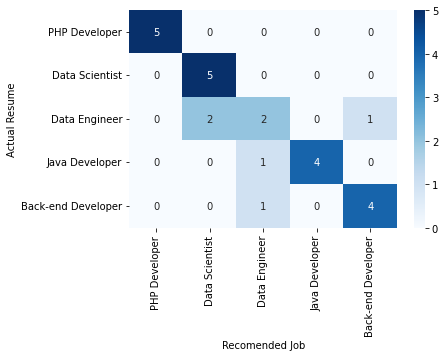

In [ ]:
plot_confusion_matrix_(Y_true,Y_pred)

In [ ]:
for i in range(10):
  print(f"job matching with cv {match_cvs[i]['name']}")
  print(f"{match_cvs[i]['pct']}")

job matching with cv r7.txt
80.0
job matching with cv r6.txt
77.27272727272727
job matching with cv r8.txt
75.0
job matching with cv r9.txt
71.42857142857143
job matching with cv r10.txt
66.66666666666666
job matching with cv r13.txt
5.555555555555555
job matching with cv r12.txt
5.128205128205128
job matching with cv r11.txt
4.878048780487805
job matching with cv r15.txt
3.571428571428571
job matching with cv r14.txt
3.125


### Cleanups


In [ ]:
##################################### delete produced resume files
i=10
while i < 30:
  print ("resume"+str(i)+".txt")
  if os.path.isfile("resume"+str(i)+".txt"):
    print ("found")
    path = "resume"+str(i)+".txt" 
    os.remove(path)
    print ("deleted")
    print ("..........")
  else:
    print ("not found")
  i+=1

resume10.txt
found
deleted
..........
resume11.txt
found
deleted
..........
resume12.txt
found
deleted
..........
resume13.txt
found
deleted
..........
resume14.txt
found
deleted
..........
resume15.txt
found
deleted
..........
resume16.txt
found
deleted
..........
resume17.txt
found
deleted
..........
resume18.txt
found
deleted
..........
resume19.txt
found
deleted
..........
resume20.txt
found
deleted
..........
resume21.txt
found
deleted
..........
resume22.txt
found
deleted
..........
resume23.txt
found
deleted
..........
resume24.txt
found
deleted
..........
resume25.txt
found
deleted
..........
resume26.txt
found
deleted
..........
resume27.txt
found
deleted
..........
resume28.txt
found
deleted
..........
resume29.txt
found
deleted
..........


In [ ]:
###################deleting the saved model#################################
#  !rm -rf model2


### xxxxx


In [ ]:
###################loading the saved model################################
output_dir='./model2'
nlp2 = spacy.load(output_dir)

In [ ]:
#######################reading the file from folder######################
f = open('/content/drive/My Drive/five_class_entitydata/feed1.txt', 'r')
text = f.read()
# text="im competent in java,c# and python"
# text=cleandata(text)

In [ ]:
docx=nlp2(text)
d = {}
for ent in docx.ents:
  d[ent.label_] = []
for ent in docx.ents:
  d[ent.label_].append(ent.text)
if 'Skills' in d:
  skills_=d['Skills']    
  print(f'Dedected skills {skills_}')

In [ ]:
#########################viewving the results####################
from spacy import displacy
displacy.render(nlp_, style='ent',jupyter=True)